# Import libraries

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.pandas
from itertools import product
from matplotlib import image
from matplotlib import pyplot

from PIL import Image
from skimage import io, color, exposure, transform, img_as_float32
import skimage
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE

from os import listdir
from os.path import isfile, join

from dask import bag, diagnostics
from scipy import stats

from pathlib import Path
import os, sys

sys.path.insert(0, str(Path.cwd().parent))
import leukopy_lib as leuko
from importlib import reload
reload(leuko)

import umap
import umap.plot

from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Import dataframe (id/path/label)

In [106]:
# Loading images paths
files = []
ids = []
labels = []

path_gen = r"/Users/yahiabouzoubaa/Downloads/PBC_dataset_normal_DIB"
path_loc = [r"/basophil",r"/eosinophil",r"/erythroblast",r"/ig",
            r"/lymphocyte",r"/monocyte",r"/neutrophil",r"/platelet"]

for x in path_loc:
    path = path_gen + x
    files.extend([join(path, f)  for f in listdir(path)])

# Creating the dataframe
df = pd.DataFrame(columns = ["path", "id", "label"])

df["path"] = files
df["id"] = df["path"].apply(lambda x : x.split('_')[4][:-4])
df["label"] = df["path"].apply(lambda x : x.split('_')[3].split('/')[-1])

# Readjusting the labels
df["label"] = df["label"].replace(to_replace = ["BNE","NEUTROPHIL","MY","MMY","PMY"], 
                                  value = ["IG","SNE","IG","IG","IG"])
df = df[df['label'] != '.DS']

# Value counts of the labels
print(df["label"].value_counts())

# Stockage de chacun des 8 labels dans la liste classes
df.head()

IG          4528
EO          3117
PLATELET    2348
SNE         1696
ERB         1551
MO          1420
BA          1218
LY          1214
Name: label, dtype: int64


,path,id,label
0,/Users/yahiabouzoubaa/Downloads/PBC_dataset_normal_DIB/basophil/BA_689200.jpg,689200,BA
1,/Users/yahiabouzoubaa/Downloads/PBC_dataset_normal_DIB/basophil/BA_883452.jpg,883452,BA
2,/Users/yahiabouzoubaa/Downloads/PBC_dataset_normal_DIB/basophil/BA_382161.jpg,382161,BA
3,/Users/yahiabouzoubaa/Downloads/PBC_dataset_normal_DIB/basophil/BA_175579.jpg,175579,BA
4,/Users/yahiabouzoubaa/Downloads/PBC_dataset_normal_DIB/basophil/BA_775722.jpg,775722,BA


# Preparing the data for PCA

<AxesSubplot:xlabel='label', ylabel='count'>

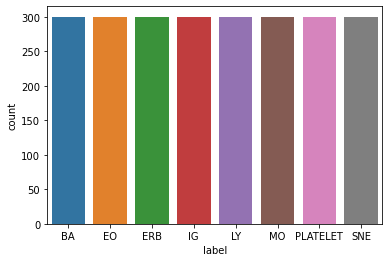

In [107]:
# Sampling from dataframe
sample = df.groupby('label').apply(lambda x: x.sample(n=300)).reset_index(drop = True)
sns.countplot(x=sample.label)

In [108]:
# Loading grayscaled images
np_data = []
for i in sample['path']:
    img = np.asarray(Image.open(i).resize((363,360)).convert('L')).reshape(-1)
    np_data.append(img)

# Converting to dataframe
np_feats = np.transpose(np_data)
df_data = pd.DataFrame(np_feats)
df_data = df_data.transpose()

# Encoding the labels
le = preprocessing.LabelEncoder()
target = le.fit_transform(sample.label)
le.classes_

array(['BA', 'EO', 'ERB', 'IG', 'LY', 'MO', 'PLATELET', 'SNE'],
      dtype=object)

# PCA model

In [109]:
# Applying the PCA to our data
pca = PCA(n_components = 0.9)
X_pca = pca.fit_transform(df_data)

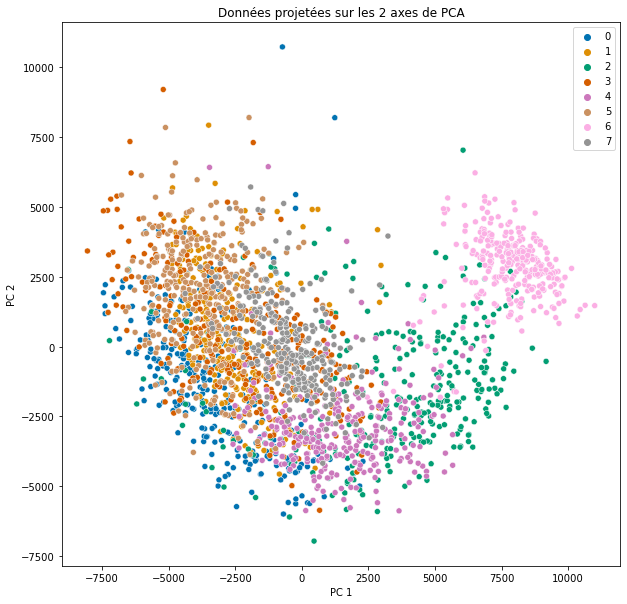

<Figure size 432x288 with 0 Axes>

In [110]:
# Plotting our results
fig, ax = pyplot.subplots(figsize=(10,10))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue = target, palette = 'colorblind')

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')

ax.set_title("Données projetées sur les 2 axes de PCA")
plt.show();
fig = plt.figure()


## It looks like our PCA model is able to distinguish between some categories. In fact, as we will see later on, it is very efficient in clustering the platelets (light pink dots).

/Users/yahiabouzoubaa/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


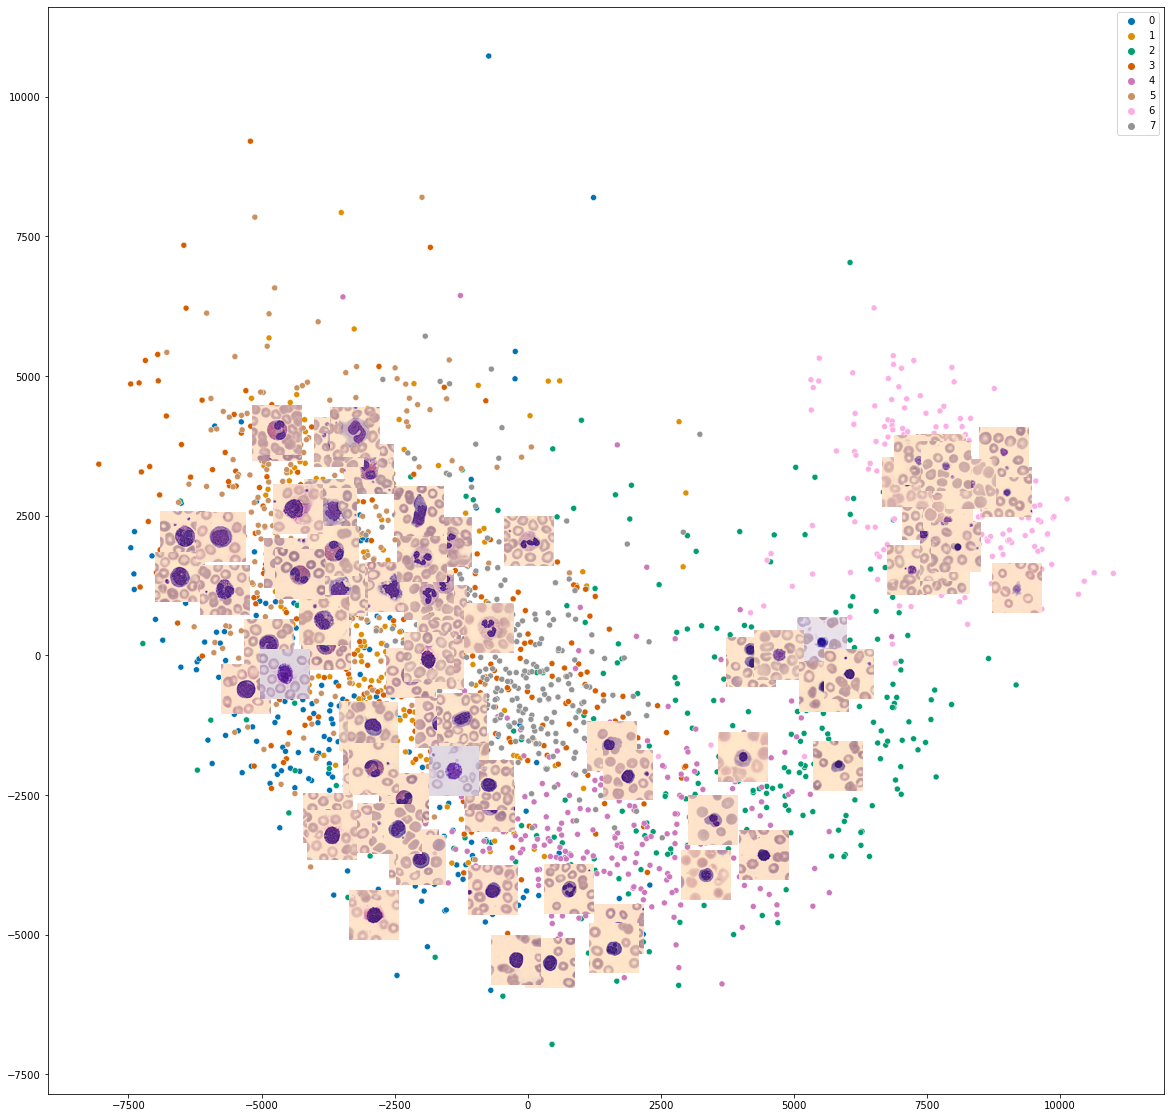

In [111]:
# preparing the annotated images for the plot
sample['X'] = X_pca[:, 0]
sample['Y'] = X_pca[:, 1]
sample2 = sample.sample(frac=0.035)

# Plotting the previous scatter plot with annotated images for our data

def getImage(path):
    return OffsetImage(np.asarray(Image.open(path).resize((50,50))))



paths = sample2.path
x1=np.array(sample2.X)
y1=np.array(sample2.Y)


x = X_pca[:, 0]
y = X_pca[:, 1]

fig, ax = plt.subplots(figsize=(20, 20))
sns.scatterplot(x, y, hue = target, palette = 'colorblind')


for x0, y0, path in zip(x1, y1,paths):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
    ax.add_artist(ab)

## Just as we said previously, the PCA has been able to distinguish between categories according to the size of the bloodcells in the images, which makes it really useful for detecting platelet.

# LDA Model

In [67]:
# Applying the LDA to our data
lda = LDA()
X_lda = lda.fit_transform(df_data,target)

# Preparing for the results plotting
sample['X_lda'] = X_lda[:, 0]
sample['Y_lda'] = X_lda[:, 1]
sample2 = sample.sample(frac=0.05)

/Users/yahiabouzoubaa/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


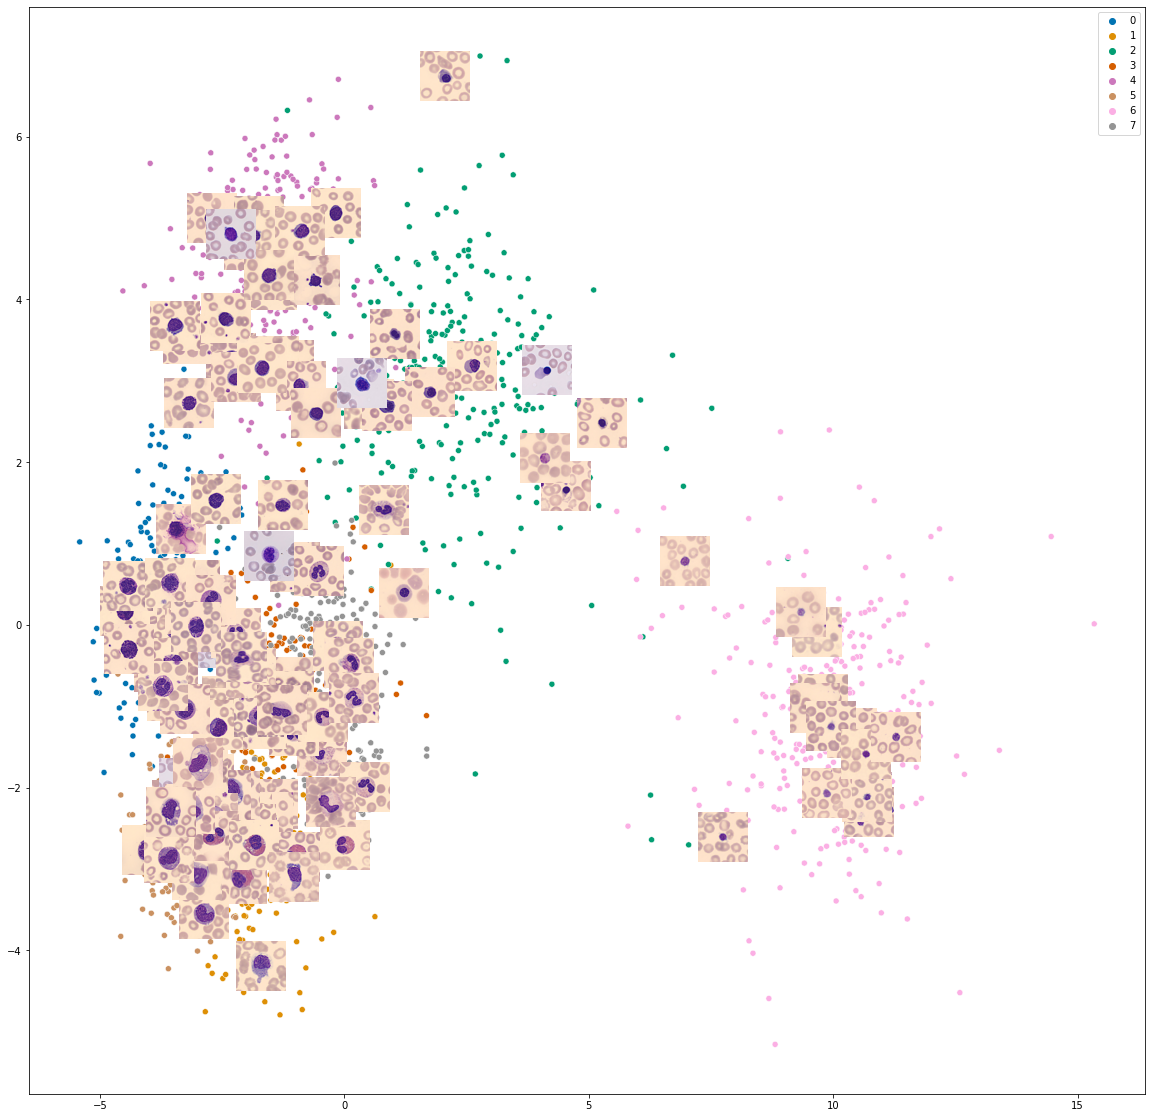

In [68]:
# Plotting the results
def getImage(path):
    return OffsetImage(np.asarray(Image.open(path).resize((50,50))))



paths = sample2.path
x1=np.array(sample2.X_lda)
y1=np.array(sample2.Y_lda)


x = X_lda[:, 0]
y = X_lda[:, 1]

fig, ax = plt.subplots(figsize=(20, 20))
sns.scatterplot(x, y, hue = target, palette = 'colorblind')
for x0, y0, path in zip(x1, y1,paths):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
    ax.add_artist(ab)



## Amazing ! Once again, we have been able to visually cluster some categories according to the bloddcell size.

# t-SNE Model

In [78]:
# Applying t-SNE to our data
tsne = TSNE(n_components=2, perplexity = 40 ,method = 'barnes_hut')
dataTSNE = tsne.fit_transform(df_data)

/Users/yahiabouzoubaa/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


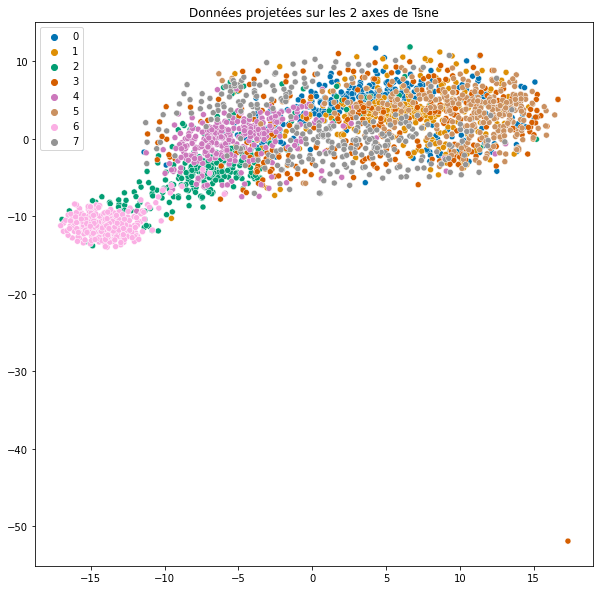

In [81]:
# Plotting the results
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(111)
sns.scatterplot(dataTSNE[:, 0], dataTSNE[:, 1], hue = target, palette = 'colorblind')


ax.set_title("Données projetées sur les 2 axes de Tsne")
plt.show();

# UMAP Visualisations 

In [83]:
# Preparing the data
dfile_bag = bag.from_sequence(df.path.to_list()).map(leuko.load_image, 
                                                          as_grey=True, 
                                                          rescale=0.5)
with diagnostics.ProgressBar():
    images = np.array(dfile_bag.compute())
le = preprocessing.LabelEncoder()
target = le.fit_transform(df.label)
le.classes_
images_flat = images.reshape(images.shape[0], -1)

In [90]:
# Applying our UMAP model
%%time
mapper = umap.UMAP(n_neighbors=5, random_state=42, n_jobs=6).fit(images_flat)
embedding = mapper.transform(images_flat)

CPU times: user 1min 55s, sys: 14.6 s, total: 2min 10s
Wall time: 1min 2s


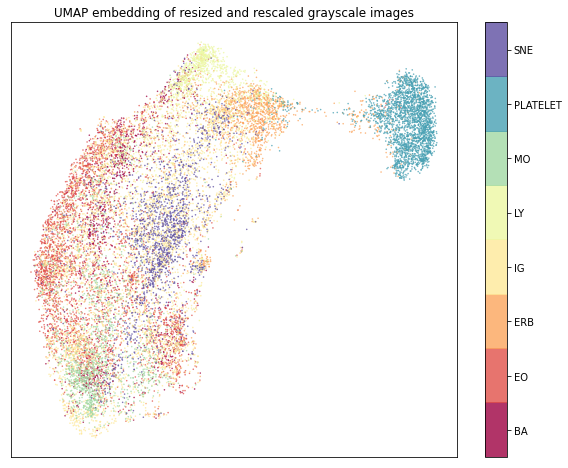

In [91]:
# Plotting the results
fig, ax = plt.subplots(1, figsize=(10, 8))
plt.scatter(*embedding.T, s=0.3, c=target, cmap='Spectral', alpha=0.8)
plt.setp(ax, xticks=[], yticks=[])

cbar = plt.colorbar(boundaries=np.arange(len(le.classes_)+1)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(le.classes_)
plt.title('UMAP embedding of resized and rescaled grayscale images');

<AxesSubplot:title={'center':'Colored by RGB coords of PCA embedding'}>

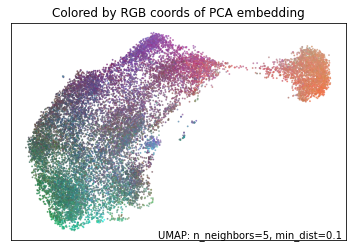

In [114]:
# Other visualisation
umap.plot.diagnostic(mapper, diagnostic_type='pca')

<AxesSubplot:>

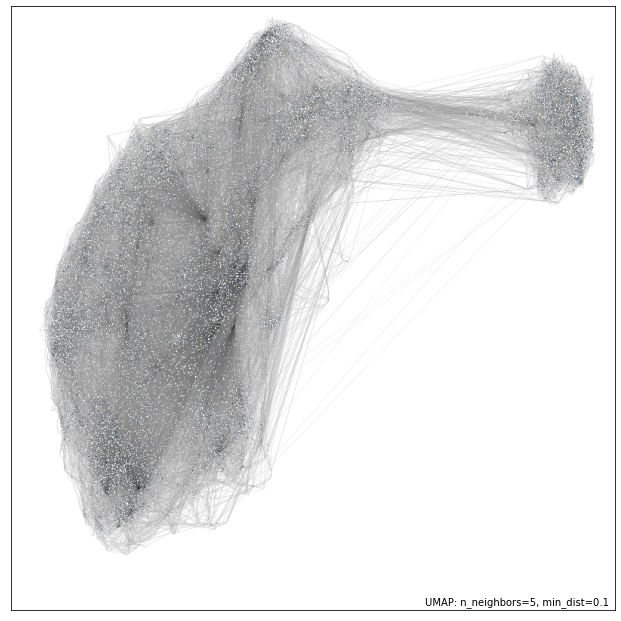

In [93]:
# Other visualisation
umap.plot.connectivity(mapper, show_points=True)

In [94]:
# Preparing a sample
sample = df.groupby('label').sample(n=400)
sample.label.value_counts()
sample_im = images_flat[sample.index]

SNE         400
MO          400
LY          400
IG          400
EO          400
BA          400
PLATELET    400
ERB         400
Name: label, dtype: int64

In [96]:
# Applying umap to our sample
%%time
mapper_s = umap.UMAP(random_state=42, n_jobs=6).fit(sample_im)
embedding_S = mapper.transform(sample_im)

sample['X'] = embedding_S[:, 0]
sample['Y'] = embedding_S[:, 1]

sample2 = sample.sample(frac=0.035)
sample2
paths = sample2.path
x_coord = sample2.X.to_list()
y_coord = sample2.Y.to_list()

CPU times: user 3min 11s, sys: 5.92 s, total: 3min 17s
Wall time: 3min 18s


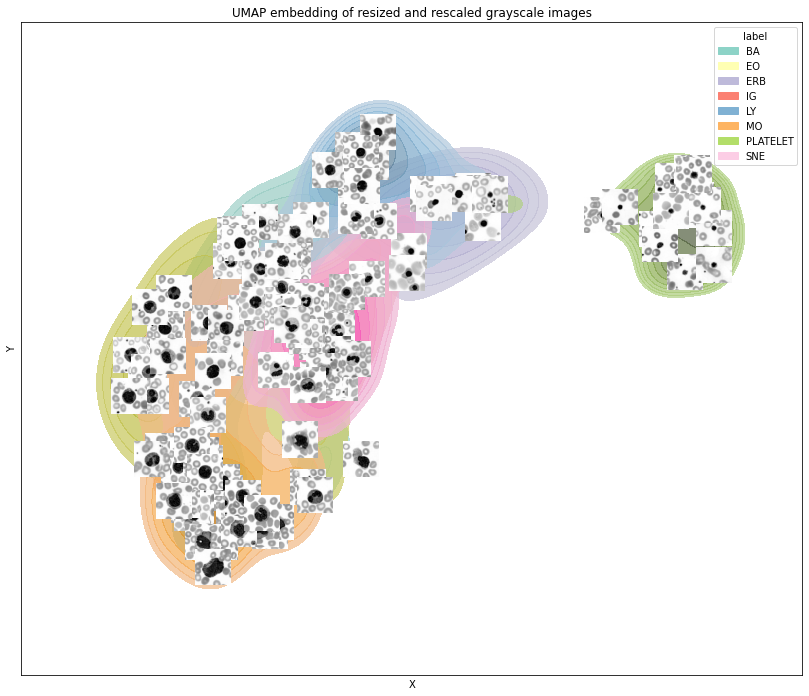

In [99]:
# Plotting the results
fig, ax = plt.subplots(1, figsize=(14, 12))
sns.kdeplot(x=sample.X, y=sample.Y, hue='label', data=sample, shade=True, thresh=0.2, alpha=0.7, palette='Set3')
plt.setp(ax, xticks=[], yticks=[])

plt.title('UMAP embedding of resized and rescaled grayscale images')


def getImage(path):
    return OffsetImage(leuko.load_image(path, as_grey=True, rescale=0.1),
                      cmap='gray')

for x, y, path in zip(x_coord, y_coord, paths):
    ab = AnnotationBbox(getImage(path), (x, y), frameon=False)
    ax.add_artist(ab)

/Users/yahiabouzoubaa/opt/anaconda3/lib/python3.8/site-packages/umap/plot.py:854: UserWarning: Hammer edge bundling is expensive for large graphs!
This may take a long time to compute!
  warn(


<AxesSubplot:>

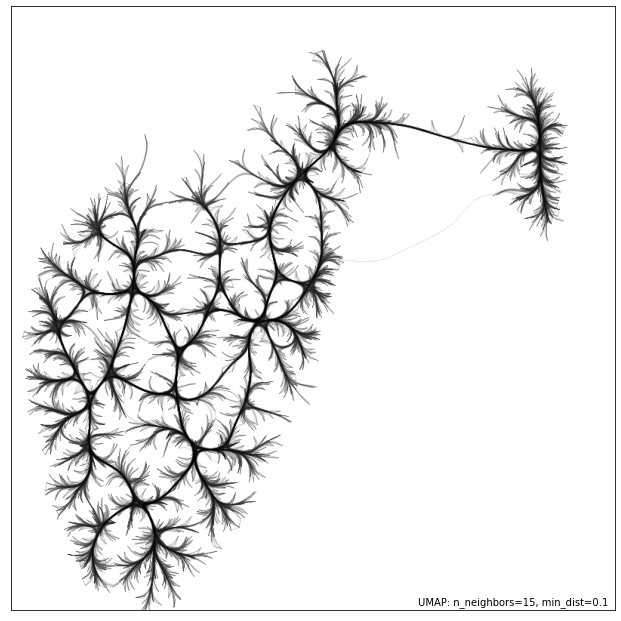

In [100]:
# Other visualisation
umap.plot.connectivity(mapper_s, edge_bundling='hammer')

In [101]:
# Using supervised learning umap version
%%time
embedding_lab = umap.UMAP().fit_transform(images_flat, y=target)

CPU times: user 5min 3s, sys: 12.7 s, total: 5min 16s
Wall time: 1min 12s


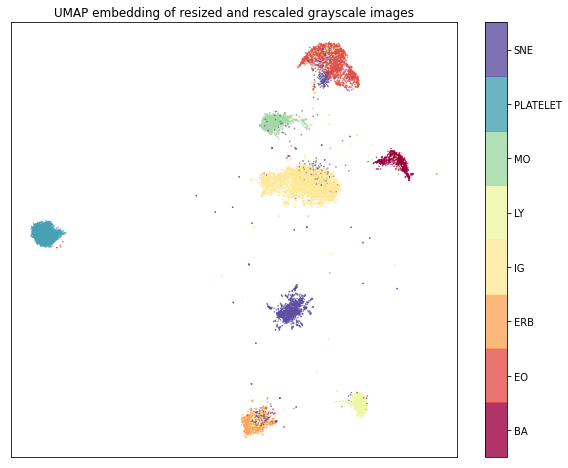

In [102]:
# Plotting results
fig, ax = plt.subplots(1, figsize=(10, 8))
plt.scatter(*embedding_lab.T, s=0.3, c=target, cmap='Spectral', alpha=0.8)
plt.setp(ax, xticks=[], yticks=[])

cbar = plt.colorbar(boundaries=np.arange(len(le.classes_)+1)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(le.classes_)
plt.title('UMAP embedding of resized and rescaled grayscale images');